# Logistic Regression: Loan Approval — Step‑by‑Step (Colab Tutorial)

**Goal:** Learn *how weights update* and *how the decision boundary appears* using a tiny 2‑feature dataset: **salary** and **loan amount** → output: **approve (1) or reject (0)**.

**How to use:** Run each cell from top to bottom. Each step is short and self‑contained.


## Step 1 — Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make printing easier to read
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.precision', 4)


## Step 2 — Make a tiny dataset

We create two features and a label:
- `salary` (scaled 0–1)
- `loan_amount` (scaled 0–1)
- `approve` (1) or `reject` (0)

You can open the CSV later if you want to see raw values.


In [11]:
# Reproducible random data (already saved as CSV for reference)
from pathlib import Path

rng = np.random.default_rng(7)

# Load the prepared CSV so students can also download it if needed
df = pd.read_csv('/content/loan_toy_simple.csv')
df.head()


,salary_lakhs,loan_lakhs,approve
0,12.0015,1.2712,1
1,16.3554,12.9408,1
2,14.4110,16.0674,1
3,5.6033,10.7471,0
4,6.8027,14.7911,0


## Step 3 — Scale features and visualize

We scale to [0,1] for stable/fast gradient descent, then scatter‑plot the two classes.


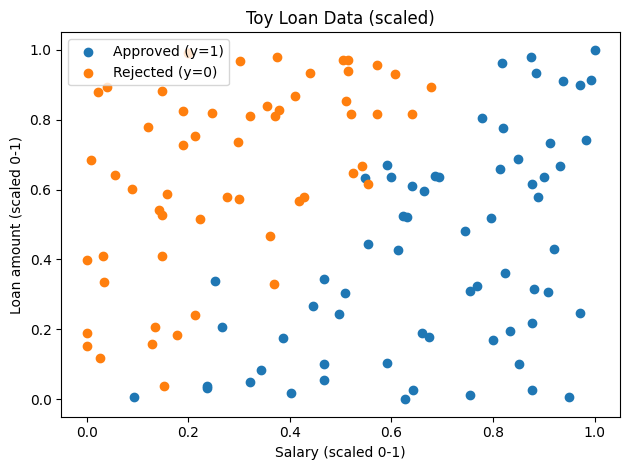

In [12]:
def minmax(a: np.ndarray):
    return (a - a.min()) / (a.max() - a.min())

salary = minmax(df['salary_lakhs'].values)
loan   = minmax(df['loan_lakhs'].values)
y      = df['approve'].values.astype(float)

X = np.column_stack([salary, loan])  # shape (n, 2)

# Quick scatter
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], label='Approved (y=1)')
plt.scatter(X[y==0,0], X[y==0,1], label='Rejected (y=0)')
plt.xlabel('Salary (scaled 0-1)')
plt.ylabel('Loan amount (scaled 0-1)')
plt.legend()
plt.title('Toy Loan Data (scaled)')
plt.tight_layout()
plt.show()


## Step 4 — Define the model and loss

- Sigmoid: \(\sigma(z)=1/(1+e^{-z})\)
- Logit: \(z=w^\top x + b\)
- Probability: \(p=\sigma(z)\)
- Log loss: \(-\big[y\log p + (1-y)\log(1-p)\big]\)
- Gradients: \(\nabla_w L=\frac{1}{n}X^\top(p-y),\ \partial L/\partial b=\text{mean}(p-y)\)


In [13]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(W, b, X):
    return sigmoid(X @ W + b)

def log_loss(p, y):
    eps = 1e-12
    p = np.clip(p, eps, 1-eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def gradients(W, b, X, y):
    p = predict_proba(W, b, X)
    diff = (p - y)        # shape (n,)
    dW = (X.T @ diff) / X.shape[0]
    db = np.mean(diff)
    return dW, db, p


## Step 5 — Initialize weights

We start small and random. Change the learning rate (`lr`) or epochs to see different behaviors.


In [14]:
rng = np.random.default_rng(0)
W = rng.normal(0, 0.01, size=2)
b = 0.0
lr = 0.5
epochs = 80

print('Initial W:', W)
print('Initial b:', b)


Initial W: [ 0.0013 -0.0013]
Initial b: 0.0


## Step 6 — **One** manual gradient‑descent step

We compute gradients and update once: \(W \leftarrow W - \eta\,dW\), \(b \leftarrow b - \eta\,db\).

In [15]:
# Compute current loss and one GD step
dW, db, p = gradients(W, b, X, y)
before = log_loss(p, y)

W = W - lr * dW
b = b - lr * db

dW2, db2, p2 = gradients(W, b, X, y)
after = log_loss(p2, y)

print('dW (first step):', dW)
print('db (first step):', db)
print('loss before:', round(before, 4), ' -> loss after:', round(after, 4))
print('W after one step:', W, '  b:', round(b, 4))


dW (first step): [-0.1178  0.0401]
db (first step): -0.03334904120065655
loss before: 0.6929  -> loss after: 0.6848
W after one step: [ 0.0602 -0.0214]   b: 0.0167


## Step 7 — Train for a few epochs

We log weights and loss every 10 epochs to keep output readable.


In [16]:
hist = []
for ep in range(epochs):
    dW, db, p = gradients(W, b, X, y)
    loss = log_loss(p, y)
    hist.append((ep, W.copy(), b, loss))
    W -= lr * dW
    b -= lr * db
    if ep % 10 == 0 or ep == epochs-1:
        print(f'epoch {ep:3d} | loss={loss:.4f} | W={W} | b={b:.4f}')

# Save history as a small DataFrame
hist_df = pd.DataFrame({
    "epoch": [h[0] for h in hist],
    "w1": [h[1][0] for h in hist],
    "w2": [h[1][1] for h in hist],
    "b":  [h[2] for h in hist],
    "loss": [h[3] for h in hist],
})
hist_df.tail()


epoch   0 | loss=0.6848 | W=[ 0.1162 -0.0436] | b=0.0289
epoch  10 | loss=0.6230 | W=[ 0.5913 -0.3129] | b=0.0360
epoch  20 | loss=0.5742 | W=[ 0.9962 -0.5846] | b=-0.0124
epoch  30 | loss=0.5338 | W=[ 1.3636 -0.8332] | b=-0.0635
epoch  40 | loss=0.4999 | W=[ 1.701  -1.0591] | b=-0.1117
epoch  50 | loss=0.4712 | W=[ 2.0126 -1.2655] | b=-0.1567
epoch  60 | loss=0.4466 | W=[ 2.3016 -1.4551] | b=-0.1988
epoch  70 | loss=0.4254 | W=[ 2.5709 -1.6304] | b=-0.2382
epoch  79 | loss=0.4087 | W=[ 2.7984 -1.7776] | b=-0.2716


,epoch,w1,w2,b,loss
75,75,2.6736,-1.6970,-0.2532,0.4159
76,76,2.6989,-1.7134,-0.2570,0.4141
77,77,2.7240,-1.7296,-0.2606,0.4123
78,78,2.7490,-1.7457,-0.2643,0.4105
79,79,2.7737,-1.7617,-0.2679,0.4087


## Step 8 — Plot the decision boundary

Boundary line (in scaled coordinates): when \(w_1 x_1 + w_2 x_2 + b = 0\).


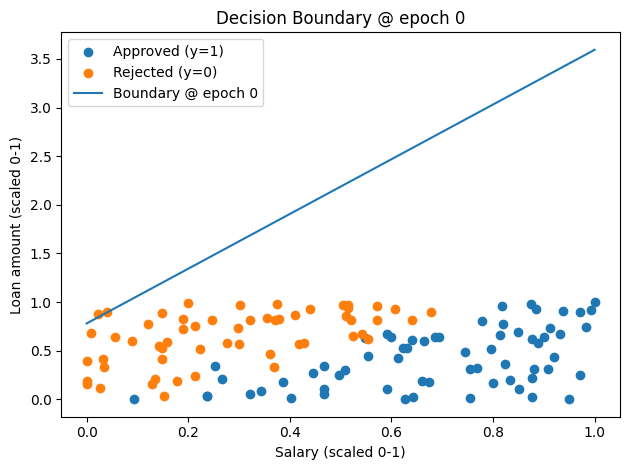

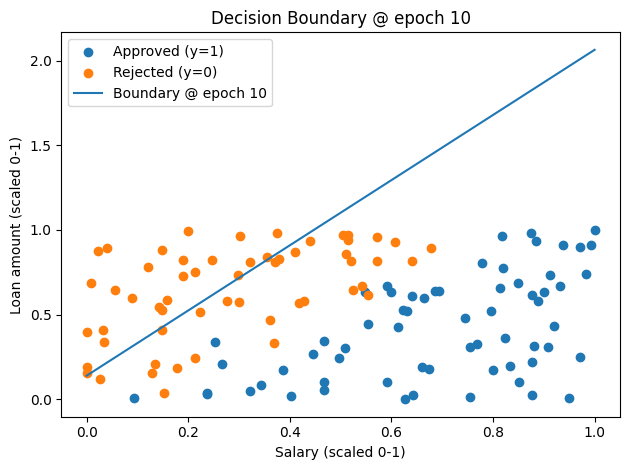

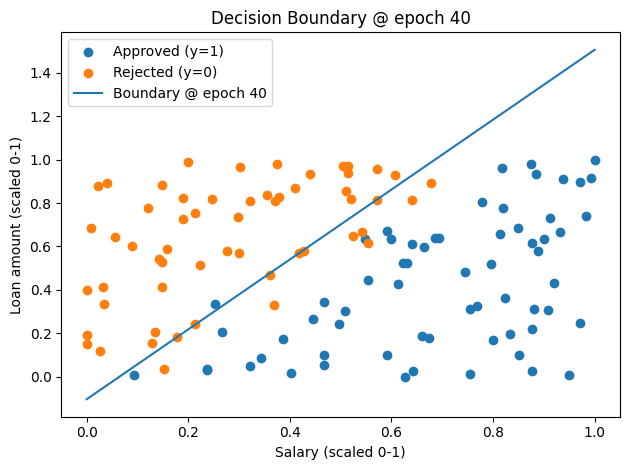

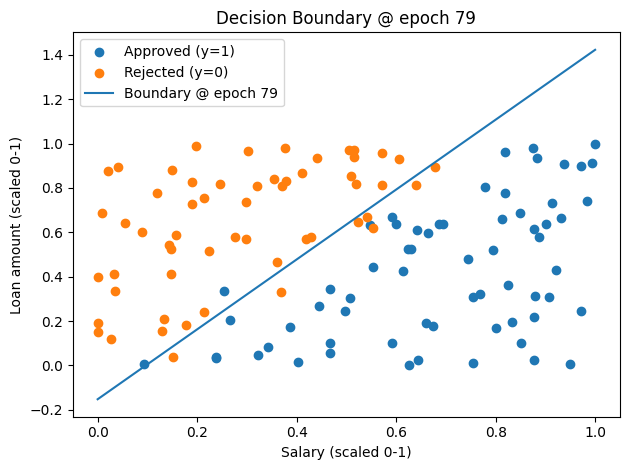

In [17]:
def boundary_points(w, b, x1_min=0.0, x1_max=1.0, num=200):
    x1 = np.linspace(x1_min, x1_max, num=num)
    if abs(w[1]) < 1e-12:
        x1_line = np.full_like(x1, -b/(w[0] if abs(w[0])>1e-12 else 1e-12))
        x2_line = np.linspace(0.0, 1.0, num=num)
        return x1_line, x2_line
    x2 = -(w[0]/w[1])*x1 - b/w[1]
    return x1, x2

# Show boundary at a few epochs (0, 10, 40, last)
snapshots = [0, 10, 40, hist_df['epoch'].iloc[-1]]
for ep in snapshots:
    row = hist_df.loc[hist_df['epoch']==ep].iloc[0]
    w = np.array([row['w1'], row['w2']])
    b_ep = row['b']
    x1_line, x2_line = boundary_points(w, b_ep)
    plt.figure()
    plt.scatter(X[y==1,0], X[y==1,1], label='Approved (y=1)')
    plt.scatter(X[y==0,0], X[y==0,1], label='Rejected (y=0)')
    plt.plot(x1_line, x2_line, label=f'Boundary @ epoch {ep}')
    plt.xlabel('Salary (scaled 0-1)')
    plt.ylabel('Loan amount (scaled 0-1)')
    plt.title(f'Decision Boundary @ epoch {ep}')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Step 9 — Loss curve

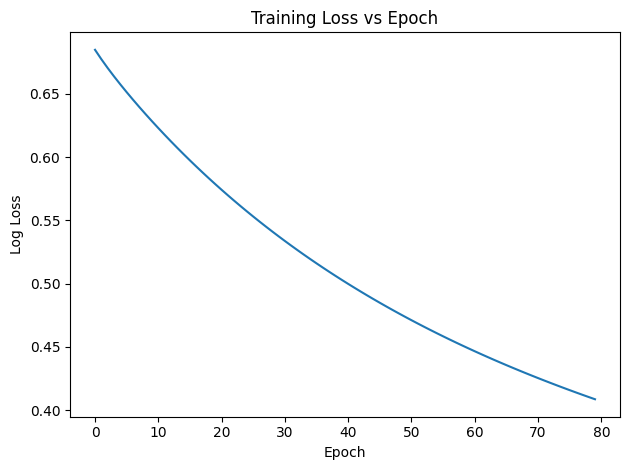

In [18]:
plt.figure()
plt.plot(hist_df['epoch'].values, hist_df['loss'].values)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Loss vs Epoch')
plt.tight_layout()
plt.show()


## Step 10 — Final accuracy

In [ ]:
p_final = predict_proba(W, b, X)
y_pred  = (p_final >= 0.5).astype(int)
acc = (y_pred == y).mean()
print('Final W:', W, '  b:', round(b,4))
print(f'Training accuracy: {acc*100:.2f}%')

Final W: [ 2.7984 -1.7776]   b: -0.2716
Training accuracy: 92.50%


## Step 11 — Try it yourself

- Change `lr` (learning rate) and `epochs` in **Step 5** and re-run from there.

- Add L2: update rule becomes `W -= lr*(dW + lambda_*W)`.

- Change the **threshold**: use `y_pred = (p_final >= 0.4).astype(int)` and observe the boundary.

- Re-generate data: edit the CSV or replace with your class data (`salary`, `loan_amount`, `approve`).

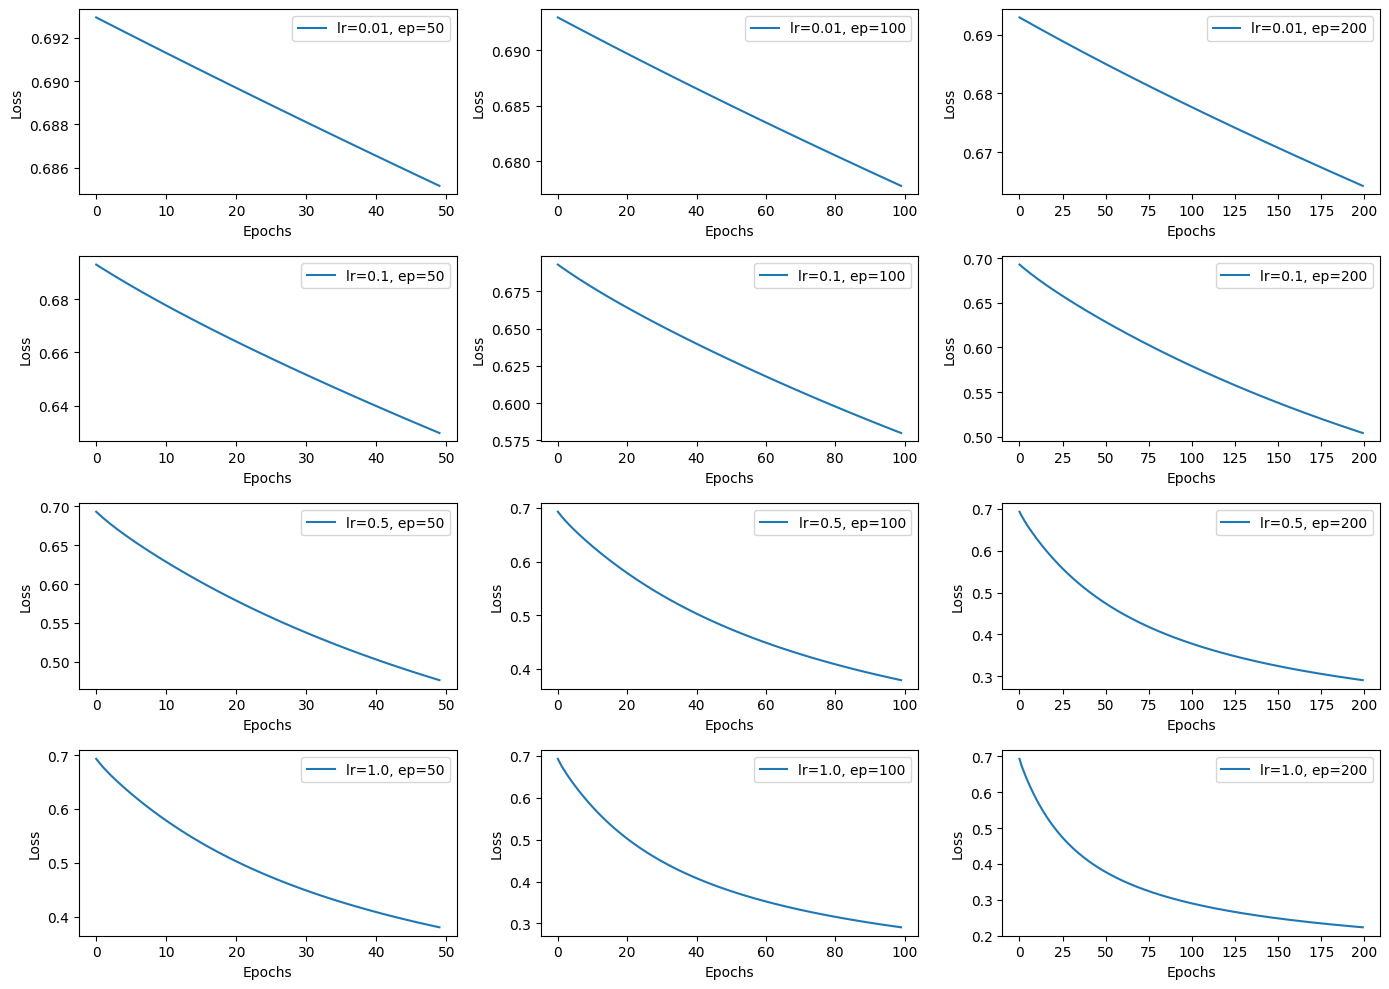

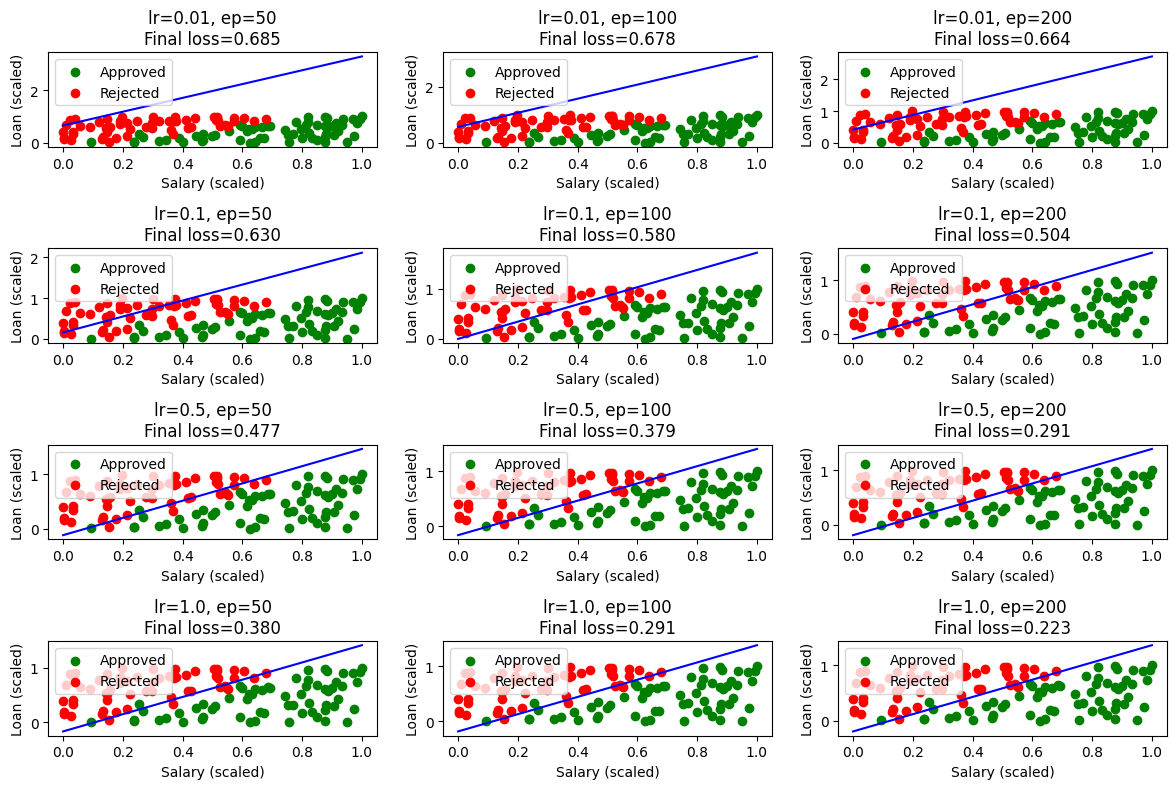

In [19]:

learning_rates = [0.01, 0.1, 0.5, 1.0]
epoch_options  = [50, 100, 200]

results = {}

plt.figure(figsize=(14, 10))

plot_id = 1
for lr in learning_rates:
    for epochs in epoch_options:

        rng = np.random.default_rng(0)
        W = rng.normal(0, 0.01, size=2)
        b = 0.0

        losses = []
        for epoch in range(epochs):
            dW, db, p = gradients(W, b, X, y)
            W -= lr * dW
            b -= lr * db
            loss = log_loss(p, y)
            losses.append(loss)


        results[(lr, epochs)] = (W, b, losses[-1])


        plt.subplot(len(learning_rates), len(epoch_options), plot_id)
        plt.plot(losses, label=f"lr={lr}, ep={epochs}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plot_id += 1

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for i, ((lr, epochs), (W, b, final_loss)) in enumerate(results.items()):
    plt.subplot(len(learning_rates), len(epoch_options), i+1)


    plt.scatter(X[y==1,0], X[y==1,1], c='g', label='Approved')
    plt.scatter(X[y==0,0], X[y==0,1], c='r', label='Rejected')


    x_vals = np.linspace(0,1,100)
    y_vals = -(W[0]*x_vals + b) / (W[1] + 1e-8)
    plt.plot(x_vals, y_vals, 'b-')

    plt.title(f"lr={lr}, ep={epochs}\nFinal loss={final_loss:.3f}")
    plt.xlabel("Salary (scaled)")
    plt.ylabel("Loan (scaled)")
    plt.legend()

plt.tight_layout()
plt.show()